# Wind Turbine Power Generation Forecasting

Train dataset contains hourly meteorological data along with power output measurements collected between January 2013 and December 2016. The data includes variables such as temperature, relative humidity, wind speed at various altitudes, and power generated at different locations.

## Prepare workspace

1. Import dependencies.

In [63]:
import numpy as np
import pandas as pd
import sklearn

from lib.util.loss_function import MEAN_SQUARED_ERROR
from lib.model.seq_model import SeqNet, ValidationData
from lib.util.progress_tracker import NotebookProgressTracker

from sklearn.model_selection import train_test_split
from src.data.wind_turbine import wind_turbine_dataset
from src.definitions import EXTERNAL_DATA_FOLDER
from src.visualization.plot import (
    plot_loss_and_val_loss,
    plot_diff,
    plot_loss_history,
)

from sklearn.discriminant_analysis import StandardScaler

2. Download and process `sudhanvahg/wind-turbine-power-generation-forecasting` dataset.

In [7]:
archive = wind_turbine_dataset.download_wind_turbine_dataset(EXTERNAL_DATA_FOLDER)

3. Split on train/test/validate. Extract free and bound variables. Scale input.

In [8]:
scaler = StandardScaler()

dataset = wind_turbine_dataset.process_wind_turbine_dataset(
    archive,
    scaler=scaler,
)

dataset.head(5)

,Temp_2m,RelHum_2m,DP_2m,WS_10m,WS_100m,WD_10m,WD_100m,WG_10m,Power,Location_1,Location_2,Location_3,Location_4
0,-0.804021,0.837857,-0.562194,-1.355386,-1.850563,-0.555885,-0.391588,-1.845008,0.151429,1,0,0,0
1,-0.808581,0.896680,-0.552661,-1.049536,-0.957421,-0.505925,-0.431150,-1.017793,0.133128,1,0,0,0
2,-0.881539,1.190795,-0.562194,-1.424449,-1.353283,-0.535901,-0.510276,-1.348679,0.114574,1,0,0,0
3,-0.854179,1.014326,-0.571727,-1.424449,-1.382727,-1.435186,-0.955355,-1.789861,0.095579,1,0,0,0
4,-0.858739,1.014326,-0.581260,-0.847281,-0.813472,-1.435186,-1.163059,-1.128089,0.076309,1,0,0,0


In [157]:
y = dataset["Power"].to_numpy()
x = dataset.drop(columns=["Power"]).to_numpy()

x_train, x_test, y_train, y_test = train_test_split(
    x, y, train_size=0.85, random_state=2024
)

y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

print("x_train = " + str(x_train.shape))
print("y_train = " + str(y_train.shape))
print("x_test = " + str(x_test.shape))
print("y_test = " + str(y_test.shape))

x_train = (119136, 12)
y_train = (119136, 1)
x_test = (21024, 12)
y_test = (21024, 1)


In [158]:
from gmdh import Criterion, CriterionType
from gmdh import PolynomialType
from gmdh import Mia, Ria

reg_criterion = Criterion(criterion_type=CriterionType.REGULARITY)


# Mia model

In [159]:
model_kwargs = {
    "criterion": reg_criterion,
    "k_best": 66,
    "test_size": 0.2,
    "p_average": 2,
    "verbose": 1,
    "limit": 1
}

MODEL_ALIAS = Mia

## Linear base polinom

In [160]:
model_linear = MODEL_ALIAS()
model_linear.fit(x_train, y_train, polynomial_type=PolynomialType.LINEAR, **model_kwargs)

LEVEL 1  [=========================] 100% :00s] (66 combinations) error=424.536325
LEVEL 2  [=========================] 100% :09s] (2145 combinations) error=395.417615
LEVEL 3  [=========================] 100% :08s] (2145 combinations) error=388.050721
LEVEL 4  [=========================] 100% :09s] (2145 combinations) error=387.430896


In [161]:
print(model_linear.get_best_polynomial())

f1_1 = 0.1256*x5 - 0.0808*x10 + 0.2743
f1_2 = 0.0946*x5 + 0.0316*x8 + 0.2543
f1_3 = - 0.0307*x3 + 0.0925*x9 + 0.2312
f1_4 = 0.1043*x9 + 0.0462*x11 + 0.2167

f2_1 = 1.0384*f1_2 + 1.2564*f1_4 - 0.3294
f2_2 = 0.9767*f1_1 + 0.8196*f1_3 - 0.2026

y = 0.6124*f2_1 + 0.4132*f2_2 - 0.0065


loss = 0.052717334827032315
R2 score = 0.5205844410578095


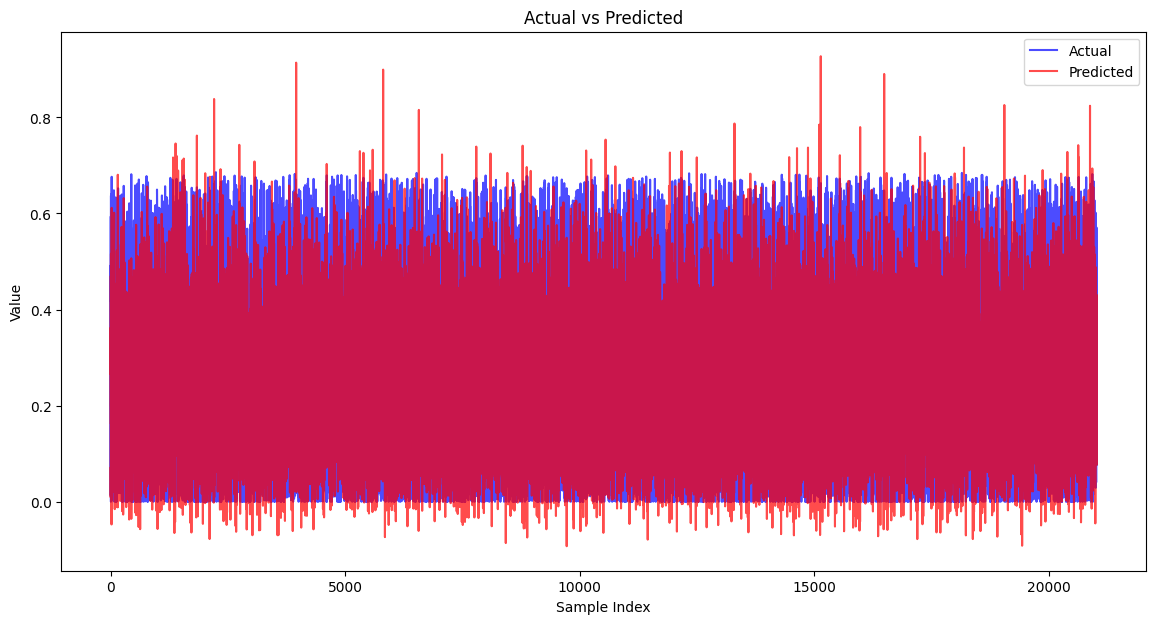

In [162]:
y_predicted = model_linear.predict(x_test)

print("loss = " + str(MEAN_SQUARED_ERROR.apply(y_test, y_predicted)))
print(
    "R2 score = "
    + str(sklearn.metrics.r2_score(y_test.flatten(), y_predicted.flatten()))
)

plot_diff(y_test.flatten(), y_predicted.flatten())

## Linear-cov base polinom

In [163]:
model_cov = MODEL_ALIAS()
model_cov.fit(x_train, y_train, polynomial_type=PolynomialType.LINEAR_COV, **model_kwargs)

LEVEL 1  [=========================] 100% :00s] (66 combinations) error=412.359939
LEVEL 2  [=========================] 100% :13s] (2145 combinations) error=380.900104
LEVEL 3  [=========================] 100% :13s] (2145 combinations) error=370.135756
LEVEL 4  [=========================] 100% :13s] (2145 combinations) error=368.33901
LEVEL 5  [=========================] 100% :12s] (2145 combinations) error=367.656822


In [164]:
print(model_cov.get_best_polynomial())

f1_1 = 0.1401*x5 - 0.0745*x10 - 0.0459*x5*x10 + 0.2755
f1_2 = 0.1106*x5 - 0.0403*x12 + 0.0418*x5*x12 + 0.2653
f1_3 = 0.0962*x5 + 0.0361*x8 - 0.0101*x5*x8 + 0.2626
f1_4 = - 0.0256*x3 + 0.0941*x9 - 0.0252*x3*x9 + 0.2313
f1_5 = 0.1043*x9 + 0.0462*x11 + 0.2167
f1_6 = 0.0844*x9 - 0.0133*x10 + 0.2366

f2_1 = - 0.8898*f1_2 - 0.7174*f1_6 + 7.7839*f1_2*f1_6 + 0.1621
f2_2 = 0.3463*f1_1 + 0.1847*f1_4 + 2.4797*f1_1*f1_4 - 0.0423
f2_3 = 0.2142*f1_3 + 0.4501*f1_5 + 3.2764*f1_3*f1_5 - 0.1252

f3_1 = 0.626*f2_1 + 0.5133*f2_2 - 0.1881*f2_1*f2_2 - 0.02
f3_2 = 0.5098*f2_2 + 0.5173*f2_3 + 0.0076*f2_2*f2_3 - 0.0075

y = 0.6826*f3_1 + 0.2943*f3_2 + 0.0475*f3_1*f3_2 + 0.0019


loss = 0.05342478284773559
R2 score = 0.5438038040947539


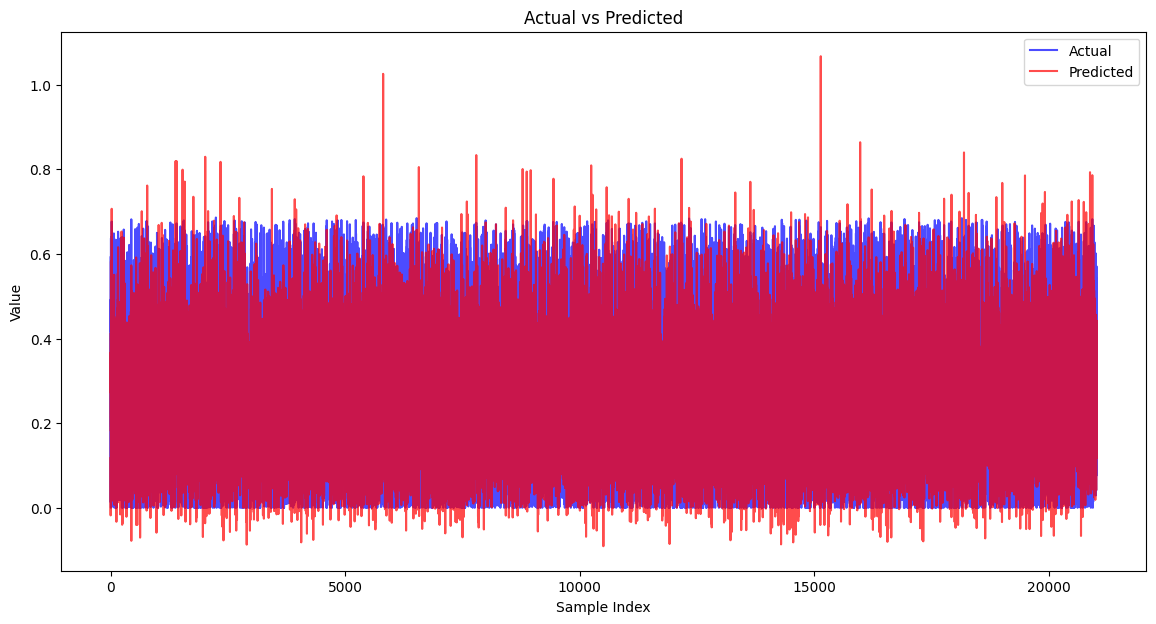

In [165]:
y_predicted = model_cov.predict(x_test)

print("loss = " + str(MEAN_SQUARED_ERROR.apply(y_test, y_predicted)))
print(
    "R2 score = "
    + str(sklearn.metrics.r2_score(y_test.flatten(), y_predicted.flatten()))
)

plot_diff(y_test.flatten(), y_predicted.flatten())

## Quadratic base polinom

In [166]:
model_quadratic = MODEL_ALIAS()
model_quadratic.fit(x_train, y_train, polynomial_type=PolynomialType.QUADRATIC, **model_kwargs)

LEVEL 1  [=========================] 100% :01s] (66 combinations) error=412.016871
LEVEL 2  [=========================] 100% :21s] (2145 combinations) error=371.012587
LEVEL 3  [=========================] 100% :21s] (2145 combinations) error=363.242256
LEVEL 4  [=========================] 100% :21s] (2145 combinations) error=357.027599
LEVEL 5  [=========================] 100% :22s] (2145 combinations) error=353.292114
LEVEL 6  [=========================] 100% :22s] (2145 combinations) error=350.381989
LEVEL 7  [=========================] 100% :21s] (2145 combinations) error=349.439542


In [167]:
print(model_quadratic.get_best_polynomial())

f1_1 = 0.1178*x5 - 8.38178e+11*x9 + 0.0581*x5*x9 - 0.0054*x5^2 + 8.38178e+11*x9^2 + 0.2297
f1_2 = 0.141*x5 + 1.7345e+11*x10 - 0.0428*x5*x10 - 0.0042*x5^2 - 1.7345e+11*x10^2 + 0.2789
f1_3 = 0.1154*x5 - 1.27343e+11*x12 + 0.0379*x5*x12 - 0.008*x5^2 + 1.27343e+11*x12^2 + 0.273
f1_4 = 0.1285*x5 - 1.37264e+11*x11 - 0.0129*x5*x11 - 0.0091*x5^2 + 1.37264e+11*x11^2 + 0.2632
f1_5 = - 0.0304*x3 + 1.23498e+11*x9 - 0.0204*x3*x9 - 0.0122*x3^2 - 1.23498e+11*x9^2 + 0.2436
f1_6 = 1.27565e+08*x9 - 3.61487e+09*x11 - 1.27565e+08*x9^2 + 3.61487e+09*x11^2 + 0.217
f1_7 = - 0.0144*x2 + 1.48107e+11*x9 - 0.0004*x2*x9 - 0.0119*x2^2 - 1.48107e+11*x9^2 + 0.243
f1_8 = - 1.32472e+08*x9 - 1.28488e+09*x10 + 1.32472e+08*x9^2 + 1.28488e+09*x10^2 + 0.2362
f1_9 = - 2.34008e+09*x10 - 9.10119e+08*x12 + 2.34008e+09*x10^2 + 9.10119e+08*x12^2 + 0.2917
f1_10 = - 1.00884e+08*x11 + 4.15062e+09*x12 + 1.00884e+08*x11^2 - 4.15062e+09*x12^2 + 0.2727

f2_1 = - 0.9949*f1_3 + 19.359*f1_8 + 6.6988*f1_3*f1_8 + 0.7687*f1_3^2 - 35.8483*f1_8

loss = 0.0542221612716876
R2 score = 0.5672656530425022


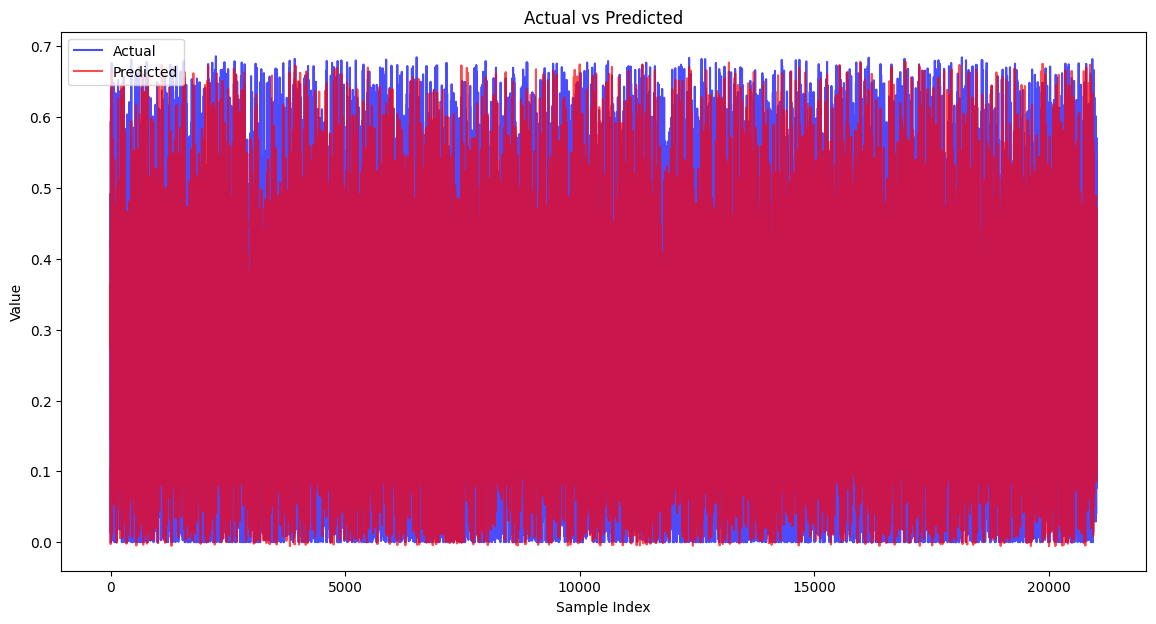

In [168]:
y_predicted = model_quadratic.predict(x_test)

print("loss = " + str(MEAN_SQUARED_ERROR.apply(y_test, y_predicted)))
print(
    "R2 score = "
    + str(sklearn.metrics.r2_score(y_test.flatten(), y_predicted.flatten()))
)

plot_diff(y_test.flatten(), y_predicted.flatten())

# Ria model

In [169]:
model_kwargs = {
    "criterion": reg_criterion,
    "k_best": 66,
    "test_size": 0.2,
    "p_average": 2,
    "verbose": 1,
    "limit": 1
}

MODEL_ALIAS = Ria

## Linear base polinom

In [170]:
model_linear = MODEL_ALIAS()
model_linear.fit(x_train, y_train, polynomial_type=PolynomialType.LINEAR, **model_kwargs)

LEVEL 1  [=========================] 100% :00s] (66 combinations) error=424.536325
LEVEL 2  [=========================] 100% :03s] (792 combinations) error=398.655425
LEVEL 3  [=========================] 100% :03s] (792 combinations) error=395.151496
LEVEL 4  [=========================] 100% :03s] (792 combinations) error=391.592433
LEVEL 5  [=========================] 100% :03s] (792 combinations) error=387.292325
LEVEL 6  [=========================] 100% :03s] (792 combinations) error=384.982919
LEVEL 7  [=========================] 100% :03s] (792 combinations) error=383.80333
LEVEL 8  [=========================] 100% :03s] (792 combinations) error=382.969631


In [171]:
print(model_linear.get_best_polynomial())

f1 = 0.0946*x5 + 0.0316*x8 + 0.2543
f2 = 0.1169*x9 + 1.0398*f1 - 0.0394
f3 = 0.0419*x11 + 1.0137*f2 - 0.014
f4 = - 0.0134*x1 + 0.9896*f3 + 0.0026
f5 = - 0.0303*x4 + 1.1977*f4 - 0.0503
f6 = 0.0239*x12 + 1.0201*f5 - 0.0111
y = 0.0121*x11 + 1.0001*f6 - 0.0031


loss = 0.05290025772086958
R2 score = 0.5258778373445838


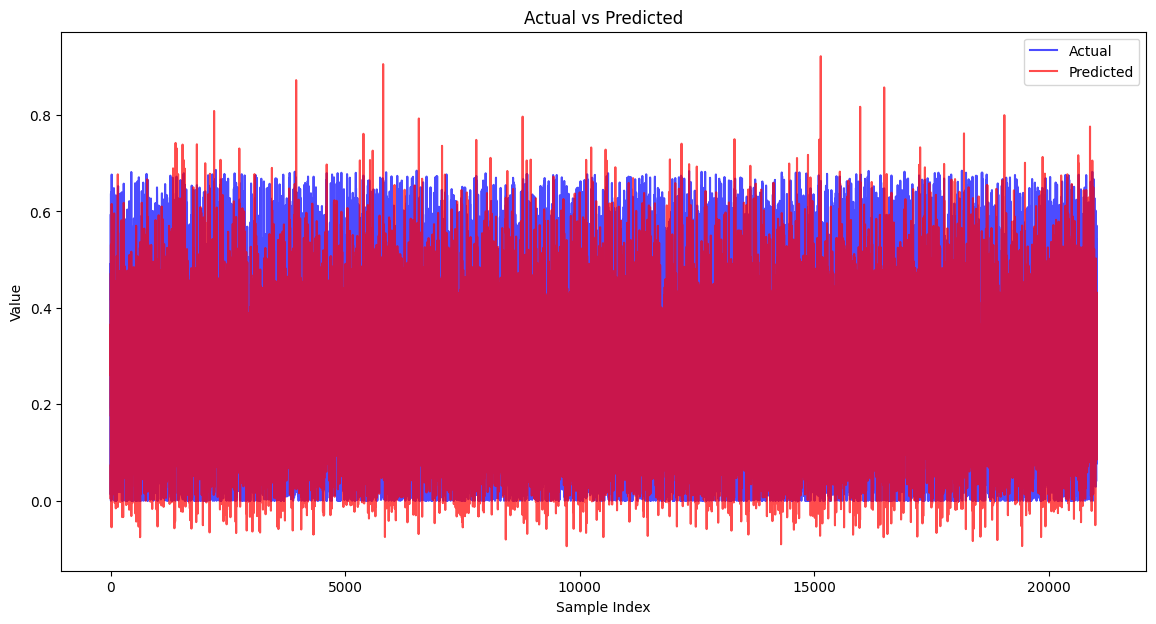

In [172]:
y_predicted = model_linear.predict(x_test)

print("loss = " + str(MEAN_SQUARED_ERROR.apply(y_test, y_predicted)))
print(
    "R2 score = "
    + str(sklearn.metrics.r2_score(y_test.flatten(), y_predicted.flatten()))
)

plot_diff(y_test.flatten(), y_predicted.flatten())

## Linear-cov base polinom

In [173]:
model_cov = MODEL_ALIAS()
model_cov.fit(x_train, y_train, polynomial_type=PolynomialType.LINEAR_COV, **model_kwargs)

LEVEL 1  [>                        ] 0% :00s] (66 combinations)

LEVEL 1  [=========================] 100% :00s] (66 combinations) error=412.359939
LEVEL 2  [=========================] 100% :05s] (792 combinations) error=384.754885
LEVEL 3  [=========================] 100% :05s] (792 combinations) error=375.493515
LEVEL 4  [=========================] 100% :05s] (792 combinations) error=369.330067
LEVEL 5  [=========================] 100% :05s] (792 combinations) error=364.348385
LEVEL 6  [=========================] 100% :05s] (792 combinations) error=363.317992
LEVEL 7  [=========================] 100% :04s] (792 combinations) error=362.461525


In [174]:
print(model_cov.get_best_polynomial())

f1 = 0.1106*x5 - 0.0403*x12 + 0.0418*x5*x12 + 0.2653
f2 = - 0.0166*x10 + 1.1279*f1 - 0.2767*x10*f1 - 0.0083
f3 = - 0.0644*x9 + 0.8938*f2 + 0.5155*x9*f2 + 0.0086
f4 = 0.031*x8 + 0.9106*f3 - 0.0432*x8*f3 + 0.0271
f5 = 0.0007*x1 + 0.9884*f4 - 0.0586*x1*f4 + 0.0021
y = 0.0085*x7 + 0.9938*f5 - 0.0101*x7*f5 + 0.0018


loss = 0.0535992487907415
R2 score = 0.5502112215164692


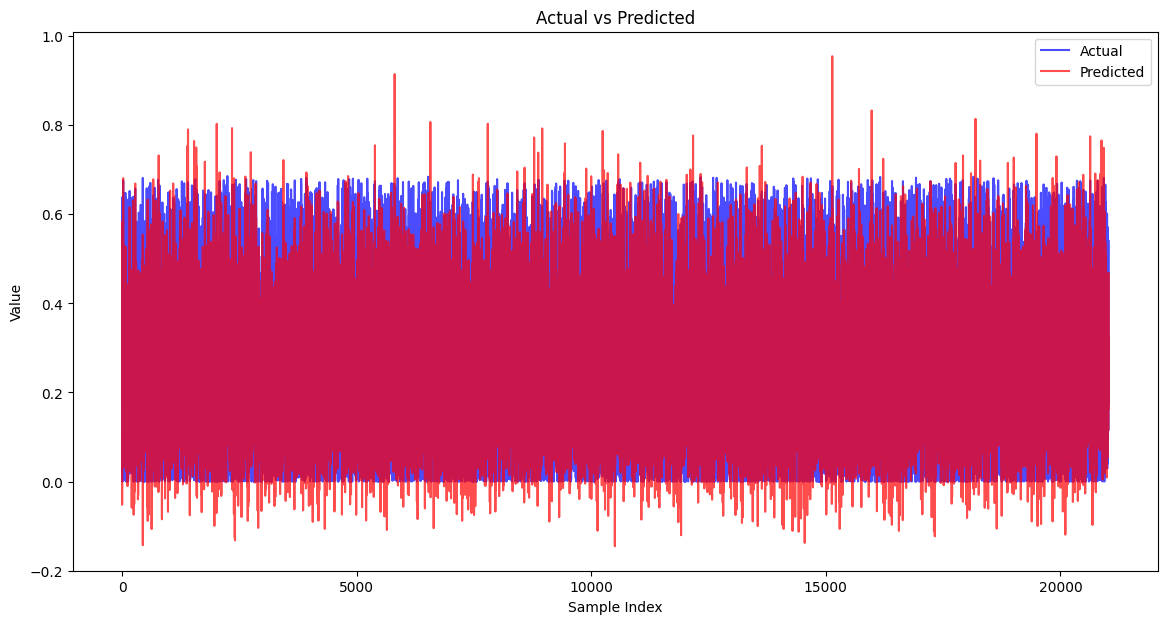

In [175]:
y_predicted = model_cov.predict(x_test)

print("loss = " + str(MEAN_SQUARED_ERROR.apply(y_test, y_predicted)))
print(
    "R2 score = "
    + str(sklearn.metrics.r2_score(y_test.flatten(), y_predicted.flatten()))
)

plot_diff(y_test.flatten(), y_predicted.flatten())

## Quadratic base polinom

In [176]:
model_quadratic = MODEL_ALIAS()
model_quadratic.fit(x_train, y_train, polynomial_type=PolynomialType.QUADRATIC, **model_kwargs)

LEVEL 1  [>                        ] 0% :00s] (66 combinations)

LEVEL 1  [=========================] 100% :00s] (66 combinations) error=412.016871
LEVEL 2  [=========================] 100% :08s] (792 combinations) error=384.042077
LEVEL 3  [=========================] 100% :07s] (792 combinations) error=370.091667
LEVEL 4  [=========================] 100% :07s] (792 combinations) error=363.042143
LEVEL 5  [=========================] 100% :07s] (792 combinations) error=357.988682
LEVEL 6  [=========================] 100% :07s] (792 combinations) error=355.639195
LEVEL 7  [=========================] 100% :07s] (792 combinations) error=349.966542
LEVEL 8  [=========================] 100% :08s] (792 combinations) error=348.016619
LEVEL 9  [=========================] 100% :08s] (792 combinations) error=346.727947
LEVEL 10 [=========================] 100% :07s] (792 combinations) error=345.792805


In [177]:
print(model_quadratic.get_best_polynomial())

f1 = 0.094*x5 + 0.0381*x8 + 0.027*x5*x8 - 0.0263*x5^2 - 0.0113*x8^2 + 0.2693
f2 = 0.3292*x4 - 3.4073*f1 - 1.7438*x4*f1 + 0.0722*x4^2 + 10.599*f1^2 + 0.406
f3 = - 2.04391e+09*x9 + 1.326*f2 + 0.157*x9*f2 + 2.04391e+09*x9^2 - 0.6554*f2^2 - 0.0532
f4 = 1.33828e+09*x11 + 0.9594*f3 - 0.0613*x11*f3 - 1.33828e+09*x11^2 + 0.1125*f3^2 - 0.0093
f5 = 0.0032*x1 + 1.0091*f4 - 0.0768*x1*f4 - 0.0045*x1^2 - 0.0405*f4^2 + 0.0045
f6 = - 1.5786e+09*x10 + 1.1314*f5 - 0.2152*x10*f5 + 1.5786e+09*x10^2 - 0.1593*f5^2 - 0.0161
f7 = - 0.0041*x4 + 1.0526*f6 + 0.0525*x4*f6 + 0.0022*x4^2 - 0.1975*f6^2 - 0.0043
f8 = - 0.0248*x5 + 1.3651*f7 + 0.0005*x5*f7 + 0.0064*x5^2 - 0.386*f7^2 - 0.0667
y = - 0.0033*x2 + 0.9831*f8 - 0.0119*x2*f8 - 0.004*x2^2 + 0.0239*f8^2 + 0.0063


loss = 0.05423594591268334
R2 score = 0.5731248974198389


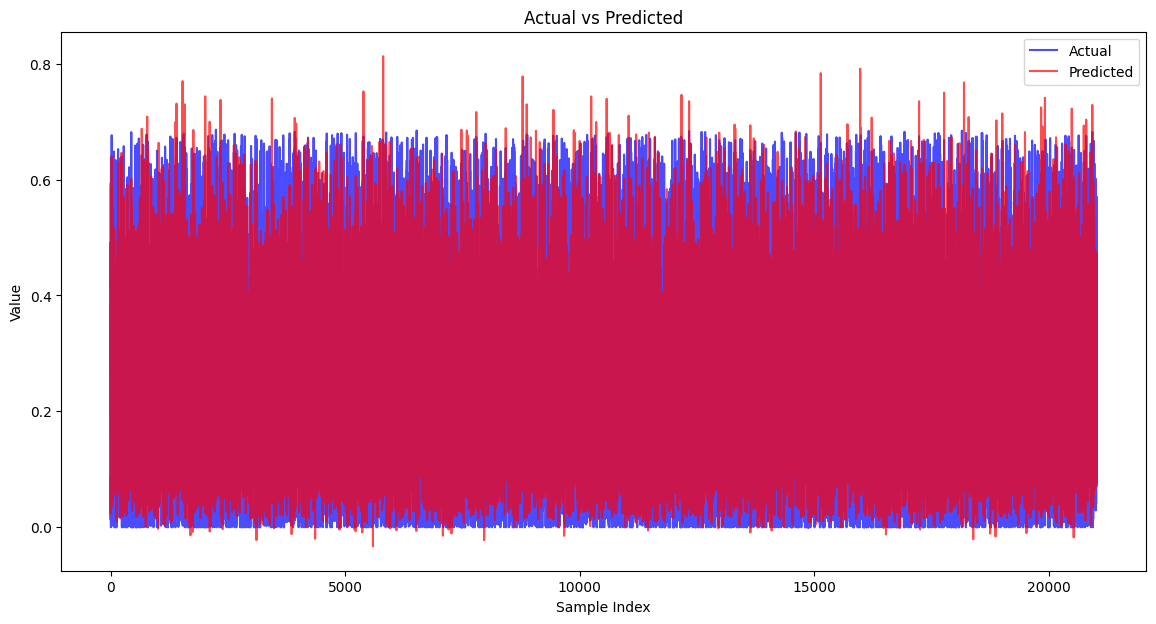

In [178]:
y_predicted = model_quadratic.predict(x_test)

print("loss = " + str(MEAN_SQUARED_ERROR.apply(y_test, y_predicted)))
print(
    "R2 score = "
    + str(sklearn.metrics.r2_score(y_test.flatten(), y_predicted.flatten()))
)

plot_diff(y_test.flatten(), y_predicted.flatten())